In [7]:
from monai.utils import set_determinism
import os, glob, torch, SimpleITK as sitk
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from random import seed, sample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from monai.networks.nets import AttentionUnet
from monai.losses import DiceFocalLoss
from monai.data import Dataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd,
    ResizeWithPadOrCropd, ToTensord, RandAffined, RandGaussianNoised,
    Rand3DElasticd, RandRotated, RandFlipd, RandShiftIntensityd
)
from monai.metrics import DiceMetric
import scipy.ndimage
import seaborn as sns
from monai.losses import DiceCELoss

In [8]:
# === SETUP ===
set_determinism(seed=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === PATHS ===
KTRANS_DIR = r"C:\Users\anude\Downloads\ProstateXKtrains-train-fixed"
DICOM_ROOT = r"C:\Users\anude\Downloads\project"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
IMAGES_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Images-Train100.csv"

# === LOAD METADATA ===
findings_df = pd.read_csv(FINDINGS_CSV)
images_df = pd.read_csv(IMAGES_CSV)
meta_df = pd.merge(images_df, findings_df, on=["ProxID", "fid"])

In [9]:


# === UTILS ===
def load_dicom_volume(proxid, series_description):
    """
    Loads a DICOM volume for a given patient and modality using series description keywords. 
    Uses fallback keyword matching to locate the correct series within nested folders.
    """
    patient_dir = os.path.join(DICOM_ROOT, proxid)
    fallback_keywords = {
        "ADC": ["adc"],
        "T2": ["t2", "t2w"],
        "DWI": ["dwi", "diffusion", "ep2d_diff", "ep2d"]
    }
    keywords = fallback_keywords.get(series_description.upper(), [series_description.lower()])
    for root, _, _ in os.walk(patient_dir):
        for keyword in keywords:
            if keyword in root.lower():
                dicoms = sorted(glob.glob(os.path.join(root, "*.dcm")))
                if dicoms:
                    reader = sitk.ImageSeriesReader()
                    reader.SetFileNames(dicoms)
                    return reader.Execute()
    raise FileNotFoundError(f"{proxid}: {series_description} not found.")

def load_ktrans(proxid):
    """
    Loads the .mhd Ktrans image for the specified patient if it exists. Returns a SimpleITK.Image or None.
    """
    path = os.path.join(KTRANS_DIR, proxid, f"{proxid}-Ktrans.mhd")
    return sitk.ReadImage(path) if os.path.exists(path) else None

def parse_ijk(ijk_str):
    """
    Parses a string of IJK coordinates into a tuple of integers. Returns None if parsing fails.
    """
    try: return tuple(map(int, ijk_str.strip().replace(",", " ").split()))
    except: return None

def generate_label_mask(image, ijk_list):
    """
    Generates a binary label mask from a list of IJK lesion coordinates aligned with the reference image. Sets voxels at lesion locations to 1.
    """
    label = np.zeros(sitk.GetArrayFromImage(image).shape, dtype=np.uint8)
    for i, j, k in ijk_list:
        try: label[int(k), int(j), int(i)] = 1
        except: continue
    result = sitk.GetImageFromArray(label)
    result.CopyInformation(image)
    return result

def keep_largest_component(pred_mask):
    """
    Removes small connected components from predicted masks, retaining only the largest structure in each prediction.
    Helps reduce noise and false positives.
    """
    cleaned = []
    for m in pred_mask:
        labeled_array, num_features = scipy.ndimage.label(m)
        if num_features == 0:
            cleaned.append(m)
            continue
        sizes = scipy.ndimage.sum(m, labeled_array, range(num_features + 1))
        largest = (labeled_array == np.argmax(sizes)).astype(np.uint8)
        cleaned.append(largest)
    return np.array(cleaned)
    
def tta_sliding_window(model, images):
    """
    Performs Test-Time Augmentation (TTA) by averaging predictions from original and flipped inputs 
    using sliding window inference. This enhances robustness to spatial variations during evaluation.
    """
    flips = [lambda x: x, lambda x: torch.flip(x, dims=[2])]
    preds = []
    for flip in flips:
        flipped = flip(images)
        pred = sliding_window_inference(flipped, (128, 128, 64), 1, model)
        pred = flip(pred)
        preds.append(pred)
    return torch.mean(torch.stack(preds), dim=0)

def lesion_present(pred_mask, threshold=0.5, min_voxels=300):
    """
    Determines if a lesion is present by thresholding the predicted probability map and
    keeping only the largest component. Returns 1 if the lesion exists and exceeds the voxel count threshold.
    """
    probs = torch.softmax(pred_mask, dim=1)[:, 1].cpu().numpy()
    binary = (probs > threshold).astype(np.uint8)
    binary = keep_largest_component(binary)
    return int(np.any(binary) and binary.sum() > min_voxels)

In [10]:

# === DATASET BUILD ===
os.makedirs("images", exist_ok=True)
os.makedirs("labels", exist_ok=True)
data, labels = [], []

print(" Building dataset...")
for proxid in tqdm(meta_df["ProxID"].unique()):
    try:
        adc = load_dicom_volume(proxid, "ADC")
        ktrans = load_ktrans(proxid)
        t2 = load_dicom_volume(proxid, "T2")
        dwi = load_dicom_volume(proxid, "DWI")
        # Resample all modalities to ADC space
        ktrans = sitk.Resample(ktrans, adc)
        t2 = sitk.Resample(t2, adc)
        dwi = sitk.Resample(dwi, adc)
         # Generate label mask from positive findings
        pos_findings = meta_df[(meta_df["ProxID"] == proxid) & (meta_df["ClinSig"] == 1)]
        ijk_coords = [parse_ijk(i) for i in pos_findings["ijk"].dropna()]
        ijk_coords = [c for c in ijk_coords if c is not None]
        mask = generate_label_mask(adc, ijk_coords) if ijk_coords else sitk.Image(adc.GetSize(), sitk.sitkUInt8)
        mask.CopyInformation(adc)
        # Save images and labels
        paths = {
            "adc": f"images/{proxid}_adc.nii.gz",
            "ktrans": f"images/{proxid}_ktrans.nii.gz",
            "t2": f"images/{proxid}_t2.nii.gz",
            "dwi": f"images/{proxid}_dwi.nii.gz",
            "label": f"labels/{proxid}_label.nii.gz"
        }
        sitk.WriteImage(adc, paths["adc"])
        sitk.WriteImage(ktrans, paths["ktrans"])
        sitk.WriteImage(t2, paths["t2"])
        sitk.WriteImage(dwi, paths["dwi"])
        sitk.WriteImage(mask, paths["label"])
        # Add to dataset
        data.append({"image": [paths["adc"], paths["ktrans"], paths["t2"], paths["dwi"]], "label": paths["label"]})
        labels.append(1 if ijk_coords else 0)
    except Exception as e:
        print(f" {proxid}: {e}")

print(f" Total usable samples: {len(data)}")

 Building dataset...


100%|██████████| 101/101 [01:44<00:00,  1.03s/it]

 Total usable samples: 101


In [11]:


# === BALANCE ===
has_lesion = [d for d, l in zip(data, labels) if l == 1]
no_lesion = [d for d, l in zip(data, labels) if l == 0]
neg_to_pos_ratio = 3
no_lesion_sampled = sample(no_lesion, min(len(no_lesion), len(has_lesion) * neg_to_pos_ratio))
# Final train/test split
train_data = has_lesion + no_lesion_sampled
train_labels = [1]*len(has_lesion) + [0]*len(no_lesion_sampled)
_, test_data, _, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)


# === TRANSFORMATIONS ===

test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys="image"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 64)),
    ToTensord(keys=["image", "label"])
])
# === DATALOADERS ===
test_loader = DataLoader(Dataset(test_data, transform=test_transforms), batch_size=1)

# === MODEL ===
model = AttentionUnet(
    spatial_dims=3,
    in_channels=4,
    out_channels=2,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2)
).to(device)


 Evaluating best model...

 Test Set Detection-Level Metrics:
 Accuracy:  0.7143
 Precision: 0.5000
 Recall:    0.5000
 F1 Score:  0.5000


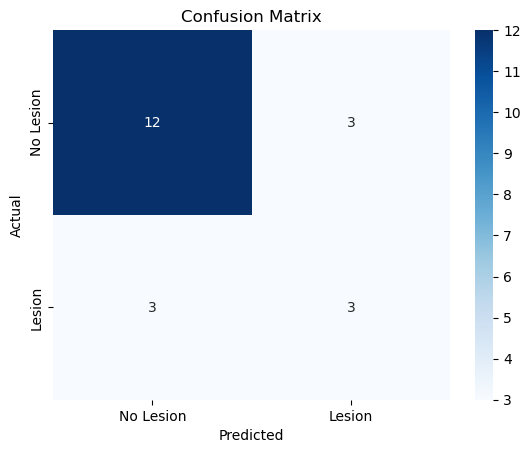

In [12]:

# === EVALUATE ===
print(" Evaluating best model...")
model.load_state_dict(torch.load(r"C:\Users\anude\Downloads\project\monai_best_model.pth"))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        true_mask = batch["label"].cpu().numpy()
        pred_mask = tta_sliding_window(model, images)
        lesion_detected = lesion_present(pred_mask)
        y_pred.append(lesion_detected)
        y_true.append(int(np.any(true_mask)))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print("\n Test Set Detection-Level Metrics:")
print(f" Accuracy:  {acc:.4f}")
print(f" Precision: {prec:.4f}")
print(f" Recall:    {rec:.4f}")
print(f" F1 Score:  {f1:.4f}")

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Lesion", "Lesion"], yticklabels=["No Lesion", "Lesion"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [32]:

DATA_DIR = r"C:\Users\anude\Downloads\processed_data"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train.csv"
LR = 1e-4
GAMMA = 3.0
BATCH_SIZE = 4
THRESHOLD = 0.5
TARGET_SHAPE = (3, 64, 64, 64)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [22]:

# === Data prep ===
df = pd.read_csv(FINDINGS_CSV)
df = df.dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str)
df['ClinSig'] = df['ClinSig'].astype(int)
df['ProxID'] = df['ProxID'].apply(lambda x: x if x.startswith("ProstateX-") else f"ProstateX-{x}")
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]


In [34]:
from torch.utils.data import DataLoader, TensorDataset
# === Resize + optional augment ===
def resize_volume(vol, target_shape, augment_flag=False):
    """
    Resizes a volume to the target shape by cropping or zero-padding, with optional augmentation.
    """
    if augment_flag:
        vol = augment(vol)
    c, d, h, w = vol.shape
    tc, td, th, tw = target_shape
    padded = np.zeros(target_shape, dtype=np.float32)
    d, h, w = min(d, td), min(h, th), min(w, tw)
    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded


# === Data loader with augment for ClinSig ===
def load_tensor_dataset(df, shape=TARGET_SHAPE, augment_clinsig=False):
    """
    Loads volume data and labels into a TensorDataset, applying augmentation only to ClinSig-positive samples.
    Returns the dataset and associated patient IDs.
    """
    x_list, y_list, ids = [], [], []
    for _, row in df.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            is_clinsig = row['ClinSig'] == 1
            vol = resize_volume(vol, shape, augment_flag=augment_clinsig and is_clinsig)
            x_list.append(vol)
            y_list.append(row['ClinSig'])
            ids.append(row['ProxID'])
        except Exception as e:
            print(f"[ERROR] Skipping {row['ProxID']}: {e}")
    x_tensor = torch.tensor(np.stack(x_list))
    y_tensor = torch.tensor(y_list, dtype=torch.float32)
    return TensorDataset(x_tensor, y_tensor), ids


# === Train/val split + duplicate ClinSig once ===
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)


# === Display counts ===
print("Val class distribution:\n", val_df['ClinSig'].value_counts())

# === Load Datasets ===

val_data, val_ids = load_tensor_dataset(val_df)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

Val class distribution:
 ClinSig
0    51
1    15
Name: count, dtype: int64


In [38]:
from torch import nn, optim

# === Deep CNN Model ===
model = nn.Sequential(
    nn.Conv3d(3, 16, 3, padding=1), nn.BatchNorm3d(16), nn.LeakyReLU(),
    nn.Conv3d(16, 32, 3, padding=1), nn.BatchNorm3d(32), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(64 * 16 * 16 * 16, 256), nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1)
).to(DEVICE)


 Final Evaluation Report:
              precision    recall  f1-score   support

 Not ClinSig       0.78      0.75      0.76        51
     ClinSig       0.24      0.27      0.25        15

    accuracy                           0.64        66
   macro avg       0.51      0.51      0.51        66
weighted avg       0.65      0.64      0.64        66


 Sample Predictions:
ProstateX-0190: Predicted=1, Actual=0
ProstateX-0052: Predicted=1, Actual=0
ProstateX-0012: Predicted=0, Actual=0
ProstateX-0160: Predicted=0, Actual=0
ProstateX-0065: Predicted=0, Actual=0
ProstateX-0079: Predicted=0, Actual=0
ProstateX-0088: Predicted=1, Actual=0
ProstateX-0021: Predicted=0, Actual=0
ProstateX-0136: Predicted=0, Actual=0
ProstateX-0110: Predicted=0, Actual=0


<Figure size 500x400 with 0 Axes>

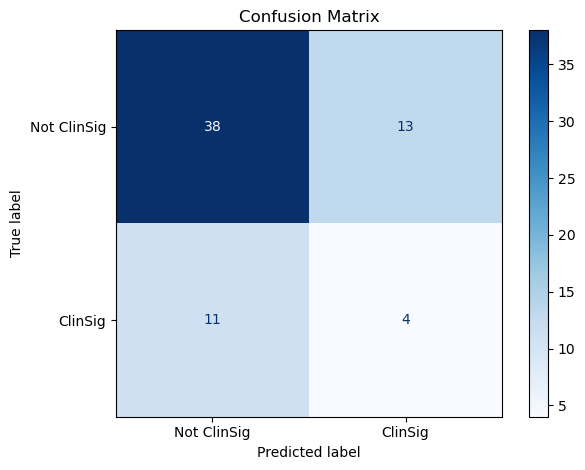

In [42]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# === Load Saved Model ===
MODEL_PATH = r"C:\Users\anude\Downloads\project\prostate_cnn_model_3DCNN.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()


all_preds, all_labels, all_proxids = [], [], []
index = 0

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        logits = model(x_batch).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > THRESHOLD).astype(int)
        preds = np.atleast_1d(preds)
        y_batch = y_batch.numpy()
        for i in range(len(preds)):
            prox_id = val_ids[index]
            all_proxids.append(prox_id)
            all_preds.append(int(preds[i]))
            all_labels.append(int(y_batch[i]))
            index += 1

# === Report ===
print("\n Final Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Not ClinSig", "ClinSig"], zero_division=0))

print("\n Sample Predictions:")
for pid, pred, label in zip(all_proxids[:10], all_preds[:10], all_labels[:10]):
    print(f"{pid}: Predicted={pred}, Actual={label}")

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [50]:
import pydicom
"""
loads and merges metadata from the ProstateX dataset, cleaning entries and parsing lesion coordinates
"""
# ==== CONFIGURATION ====
DICOM_ROOT = r"C:\Users\anude\Downloads\project"
FINDINGS_CSV = os.path.join(DICOM_ROOT, "ProstateX-Findings-Train.csv")
IMAGES_CSV = os.path.join(DICOM_ROOT, "ProstateX-Images-Train.csv")

# ==== LOAD METADATA ====
findings_df = pd.read_csv(FINDINGS_CSV)
images_df = pd.read_csv(IMAGES_CSV)

# Clean and parse 'ijk' column
images_df = images_df.dropna(subset=["ijk"])
images_df["ijk"] = images_df["ijk"].apply(lambda x: tuple(map(int, str(x).split())))

# Merge findings with image metadata
merged_df = pd.merge(findings_df, images_df, on=["ProxID", "fid"])
merged_df = merged_df.dropna(subset=["ijk", "DCMSerDescr", "ClinSig"])

# ==== FILTER FOR MODALITIES ====
modality_keywords = {
    "T2": ["t2", "t2w"],
    "ADC": ["adc"],
    "DWI": ["dwi", "diffusion", "ep2d_diff", "ep2d"]
}

#Functions

def modality_match(desc, keywords):
    """
    Checks if any of the given keywords are present in the desc string.
    """
    return any(kw.lower() in desc.lower() for kw in keywords)

# ==== IMAGE LOADING ====
def load_slice(proxid, descr_list, slice_idx):
    """
    Searches for a DICOM series under a patient's folder (proxid) matching any description in descr_list, 
    Returns the pixel array of the DICOM file.
    """
    path = os.path.join(DICOM_ROOT, proxid)
    for root, dirs, files in os.walk(path):
        for descr in descr_list:
            if descr.lower() in root.lower():
                dcm_files = sorted([f for f in os.listdir(root) if f.endswith(".dcm")])
                if 0 <= slice_idx < len(dcm_files):
                    dcm_path = os.path.join(root, dcm_files[slice_idx])
                    try:
                        ds = pydicom.dcmread(dcm_path)
                        return ds.pixel_array
                    except Exception as e:
                        print(f"Error reading {dcm_path}: {e}")
                        return None
    return None

# ==== PREPARE SAMPLES ====
samples = []
labels = []

grouped = merged_df.groupby(["ProxID", "fid"])
for _, row in tqdm(merged_df.iterrows(), total=len(merged_df), desc="Loading images"):
    proxid = row["ProxID"]
    ijk = row["ijk"]
    label = row["ClinSig"]

    img_stack = []
    valid = True
    missing_modalities = []
    for mod in modality_keywords:
        img = load_slice(proxid, modality_keywords[mod], ijk[2])
        if img is None:
            missing_modalities.append(mod)
            valid = False
            break
        from skimage.transform import resize
        img_resized = resize(img, (128, 128), mode='reflect', preserve_range=True, anti_aliasing=True)
        img_stack.append(img_resized)

    
    if not valid:
        #print(f"[WARN] Missing modalities for {proxid} fid {row['fid']} at slice {ijk[2]}: {missing_modalities}")
        continue

    # Stack modalities into 3-channel image
    stacked = np.stack(img_stack)
    samples.append(stacked)
    label = row["ClinSig"]
    labels.append(int(label))



Loading images: 100%|██████████| 3945/3945 [02:45<00:00, 23.85it/s]


In [58]:
from torch.utils.data import TensorDataset, DataLoader, random_split
X = torch.tensor(np.array(samples)).float()
y = torch.tensor(labels).long()


# define the model
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(32 * (X.shape[2] // 4) * (X.shape[3] // 4), 64), nn.ReLU(),
    nn.Linear(64, 2)
)



# === Dataset Preparation ===
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
train_ds, val_ds = random_split(dataset, [train_size, len(dataset) - train_size])
val_loader = DataLoader(val_ds, batch_size=16)

In [60]:

# ==== EVALUATION ====
model.load_state_dict(torch.load("lesion_classifier_2d.pt"))
model.to(device)

model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_true.extend(yb.numpy())

precision = precision_score(all_true, all_preds, zero_division=0)
recall = recall_score(all_true, all_preds, zero_division=0)
f1 = f1_score(all_true, all_preds, zero_division=0)
accuracy = accuracy_score(all_true, all_preds)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")
print(f"Accuracy:  {accuracy:.2f}")


Precision: 0.82
Recall:    0.95
F1 Score:  0.88
Accuracy:  0.95


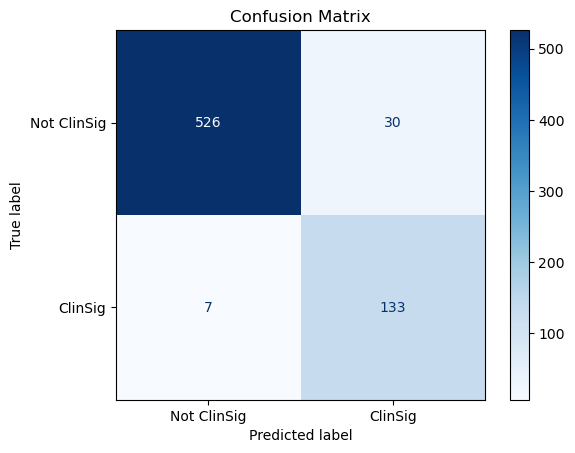


=== Sample Predictions ===
Prediction: Not ClinSig | Actual: Not ClinSig
Prediction: ClinSig | Actual: ClinSig
Prediction: ClinSig | Actual: Not ClinSig
Prediction: Not ClinSig | Actual: Not ClinSig
Prediction: Not ClinSig | Actual: Not ClinSig
Prediction: ClinSig | Actual: ClinSig
Prediction: Not ClinSig | Actual: Not ClinSig
Prediction: Not ClinSig | Actual: Not ClinSig
Prediction: Not ClinSig | Actual: Not ClinSig
Prediction: Not ClinSig | Actual: Not ClinSig


In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

# === CONFUSION MATRIX ===
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

# === SAMPLE PREDICTIONS ===
print("\n=== Sample Predictions ===")
sample_indices = random.sample(range(len(all_true)), 10)
for idx in sample_indices:
    pred = all_preds[idx]
    actual = all_true[idx]
    print(f"Prediction: {'ClinSig' if pred == 1 else 'Not ClinSig'} | Actual: {'ClinSig' if actual == 1 else 'Not ClinSig'}")
